In [1]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

sitk.ProcessObject.SetGlobalDefaultThreader('Pool')

# for CT template: license CC-BY-NC-SA and EULA https://github.com/muschellij2/high_res_ct_template/tree/master/template

True

In [2]:
def dcm_to_nii(dcmfol, resfol, name):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(dcmfol)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    sitk.WriteImage(image, f'{resfol}/{name}.nii')

    
def command_iteration(method) :
    print("{0:3} = {1:10.5f}".format(method.GetOptimizerIteration(),
                                     method.GetMetricValue()))
    print("\t#: ", len(method.GetOptimizerPosition()))


def command_multi_iteration(method) :
    print("--------- Resolution Changing ---------")

## Convert DCM to nii

In [3]:
dcm_to_nii("./data", "./", "CT")

## Bone removing

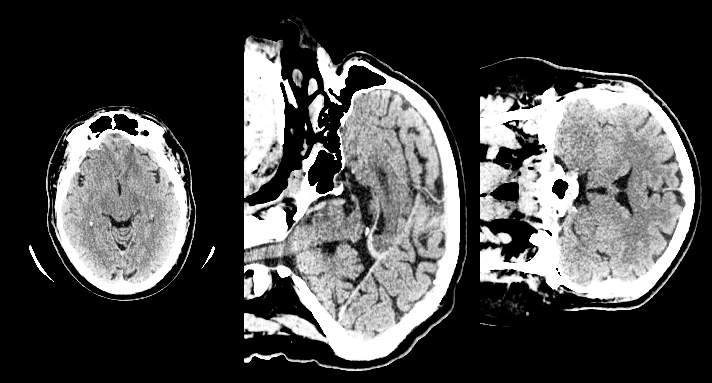

In [4]:
data_raw = sitk.ReadImage("./CT.nii", sitk.sitkFloat32)
data_raw_array = sitk.GetArrayFromImage(data_raw)
data_raw_array = data_raw_array.transpose([1,2,0])

fig, axs = plt.subplots(1, 3, figsize=(10, 10))
fig.set_tight_layout('pad')
plt.subplots_adjust(wspace=0, hspace=0)
axs[0].imshow(data_raw_array[:, :, data_raw_array.shape[2]//2], vmin=0, vmax=60, cmap="Greys_r")
axs[0].axis('off')
axs[1].imshow(data_raw_array[:, data_raw_array.shape[1]//2, :], vmin=0, vmax=60, cmap="Greys_r")
axs[1].axis('off')
axs[2].imshow(data_raw_array[data_raw_array.shape[0]//2, :, :], vmin=0, vmax=60, cmap="Greys_r")
axs[2].axis('off')
fig.set_facecolor("Black")

In [5]:
mask_stop_value = 280
bone_mask = np.zeros_like(data_raw_array)

In [6]:
data1 = sitk.DiscreteGaussian(data_raw)
bone_label = sitk.ConnectedComponent(data1 > 200)
label_stat = sitk.LabelShapeStatisticsImageFilter()
label_stat.Execute(bone_label)
label_list = [
        (i, data1.TransformPhysicalPointToIndex(label_stat.GetCentroid(i)), label_stat.GetPhysicalSize(i)) for i
        in
        label_stat.GetLabels()]
seed = max(label_list, key=lambda x: x[2])[1]
feature_img = sitk.GradientMagnitudeRecursiveGaussian(data1, sigma=.5)
speed_img = sitk.BoundedReciprocal(feature_img)
fm_filter = sitk.FastMarchingBaseImageFilter()
fm_filter.SetTrialPoints([seed]) 
fm_filter.SetStoppingValue(mask_stop_value) 
fm_img = fm_filter.Execute(speed_img)
n_mask = fm_img < mask_stop_value
bone_mask = 1 - sitk.GetArrayFromImage(n_mask).transpose([1,2,0]) < 1

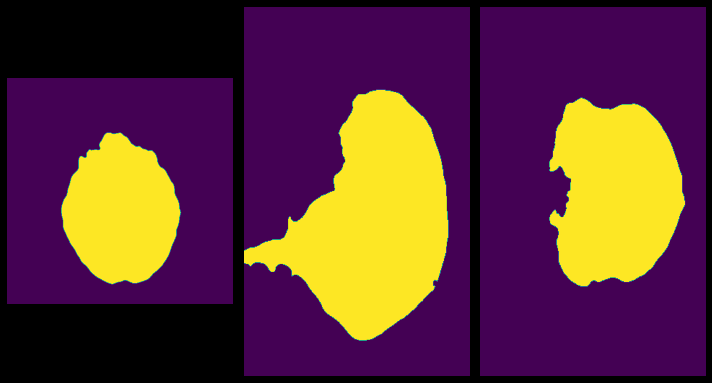

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(10, 10))
fig.set_tight_layout('pad')
plt.subplots_adjust(wspace=0, hspace=0)
axs[0].imshow(bone_mask[:, :, bone_mask.shape[2]//2])
axs[0].axis('off')
axs[1].imshow(bone_mask[:, bone_mask.shape[1]//2, :])
axs[1].axis('off')
axs[2].imshow(bone_mask[bone_mask.shape[0]//2, :, :])
axs[2].axis('off')
fig.set_facecolor("Black")

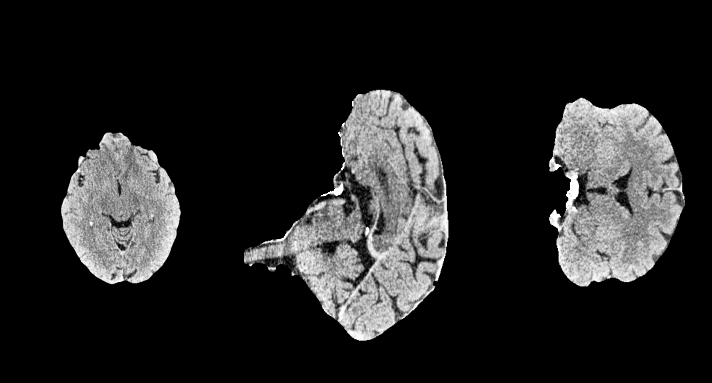

In [8]:
data = np.zeros_like(data_raw_array)
data = data_raw_array * bone_mask

fig, axs = plt.subplots(1, 3, figsize=(10, 10))
fig.set_tight_layout('pad')
plt.subplots_adjust(wspace=0, hspace=0)
axs[0].imshow(data[:, :, data.shape[2]//2], vmin=0, vmax=60, cmap="Greys_r")
axs[0].axis('off')
axs[1].imshow(data[:, data.shape[1]//2, :], vmin=0, vmax=60, cmap="Greys_r")
axs[1].axis('off')
axs[2].imshow(data[data.shape[0]//2, :, :], vmin=0, vmax=60, cmap="Greys_r")
axs[2].axis('off')
fig.set_facecolor("Black")

In [9]:
data_img = sitk.GetImageFromArray(data)

pa = sitk.PermuteAxesImageFilter()
pa.SetOrder([1,2,0])
data_img = pa.Execute(data_img)

data_img.SetSpacing(data_raw.GetSpacing())
data_img.SetDirection(data_raw.GetDirection())
data_img.SetOrigin(data_raw.GetOrigin())

sitk.WriteImage(data_img, "./CT_brain.nii")

## Reg brain to MIN template

In [10]:
fixed = sitk.ReadImage("./template.nii.gz", sitk.sitkFloat32)
moving = data_img

In [11]:
%%time
initial_transform = sitk.CenteredTransformInitializer(fixed,
                                                      moving,
                                                      sitk.Euler3DTransform(),
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
moving_resampled = sitk.Resample(moving, fixed, initial_transform, sitk.sitkLinear, 0.0, moving.GetPixelID())
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.3)
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsLBFGSB()
registration_method.SetOptimizerScalesFromPhysicalShift()
registration_method.SetInitialTransform(initial_transform, inPlace=False)
final_transform = registration_method.Execute(sitk.Cast(fixed, sitk.sitkFloat32),
                                              sitk.Cast(moving, sitk.sitkFloat32))
moving2 = sitk.Resample(moving, fixed, final_transform, sitk.sitkLinear, 0.0, moving.GetPixelID())
sitk.WriteTransform(final_transform, 'tr1.tfm')
sitk.WriteImage(moving2, "./temp_tr1.nii")

CPU times: total: 1h 57min 58s
Wall time: 5min 32s


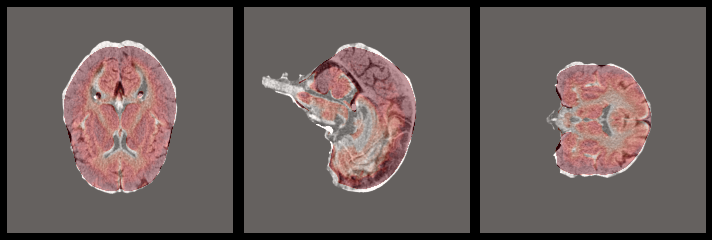

In [12]:
fixed_array = sitk.GetArrayFromImage(fixed)
fixed_array = fixed_array.transpose([1,2,0])

moving_array = sitk.GetArrayFromImage(moving2)
moving_array = moving_array.transpose([1,2,0])

fig, axs = plt.subplots(1, 3, figsize=(10, 10))
fig.set_tight_layout('pad')
plt.subplots_adjust(wspace=0, hspace=0)
axs[0].imshow(moving_array[:, :, moving_array.shape[2]//2], vmin=0, vmax=60, cmap="Greys_r")
axs[0].imshow(fixed_array[:, :, fixed_array.shape[2]//2], vmin=25, vmax=40, cmap="Reds", alpha=0.4)
axs[0].axis('off')
axs[1].imshow(moving_array[:, moving_array.shape[1]//2, :], vmin=0, vmax=60, cmap="Greys_r")
axs[1].imshow(fixed_array[:, fixed_array.shape[1]//2, :], vmin=25, vmax=40, cmap="Reds", alpha=0.4)
axs[1].axis('off')
axs[2].imshow(moving_array[moving_array.shape[0]//2, :, :], vmin=0, vmax=60, cmap="Greys_r")
axs[2].imshow(fixed_array[fixed_array.shape[0]//2, :, :], vmin=25, vmax=40, cmap="Reds", alpha=0.4)
axs[2].axis('off')
fig.set_facecolor("Black")

In [13]:
%%time

transformDomainMeshSize = [8] * moving2.GetDimension()
tx = sitk.BSplineTransformInitializer(fixed,
                                      transformDomainMeshSize)

R = sitk.ImageRegistrationMethod()
R.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
R.SetOptimizerAsGradientDescentLineSearch(5.0, 100,
                                          convergenceMinimumValue=1e-4,
                                          convergenceWindowSize=5)
R.SetOptimizerScalesFromPhysicalShift()
R.SetInitialTransform(tx)
R.SetInterpolator(sitk.sitkLinear)

R.SetShrinkFactorsPerLevel([4,2])
R.SetSmoothingSigmasPerLevel([4,2])

R.AddCommand( sitk.sitkIterationEvent, lambda: command_iteration(R) )
R.AddCommand( sitk.sitkMultiResolutionIterationEvent, lambda: command_multi_iteration(R) )

outTx = R.Execute(fixed, moving2)

--------- Resolution Changing ---------
  0 =   -0.44547
	#:  3993
  1 =   -0.46301
	#:  3993
  2 =   -0.47065
	#:  3993
  3 =   -0.47531
	#:  3993
  4 =   -0.47829
	#:  3993
  5 =   -0.48084
	#:  3993
  6 =   -0.48270
	#:  3993
  7 =   -0.48431
	#:  3993
  8 =   -0.48558
	#:  3993
  9 =   -0.48669
	#:  3993
 10 =   -0.48762
	#:  3993
 11 =   -0.48848
	#:  3993
 12 =   -0.48921
	#:  3993
 13 =   -0.48990
	#:  3993
 14 =   -0.49052
	#:  3993
 15 =   -0.49110
	#:  3993
 16 =   -0.49163
	#:  3993
 17 =   -0.49215
	#:  3993
 18 =   -0.49262
	#:  3993
 19 =   -0.49308
	#:  3993
 20 =   -0.49351
	#:  3993
 21 =   -0.49392
	#:  3993
 22 =   -0.49430
	#:  3993
--------- Resolution Changing ---------
  0 =   -0.25100
	#:  3993
  1 =   -0.36774
	#:  3993
  2 =   -0.36820
	#:  3993
  3 =   -0.36845
	#:  3993
  4 =   -0.36869
	#:  3993
  5 =   -0.36888
	#:  3993
  6 =   -0.36911
	#:  3993
  7 =   -0.36929
	#:  3993
  8 =   -0.36951
	#:  3993
  9 =   -0.36970
	#:  3993
 10 =   -0.36993
	#:  3993
 1

In [14]:
sitk.WriteTransform(outTx, 'tr2.tfm')
data_img_mni = sitk.Resample(moving2, fixed, outTx, sitk.sitkBSpline, 0.0, fixed.GetPixelID())
sitk.WriteImage(data_img_mni, "./data_img_mni.nii")

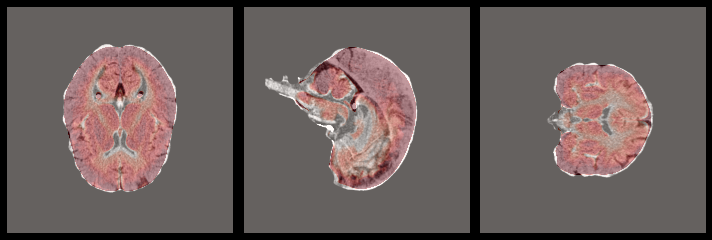

In [15]:
fixed_array = sitk.GetArrayFromImage(fixed)
fixed_array = fixed_array.transpose([1,2,0])

moving_array = sitk.GetArrayFromImage(data_img_mni)
moving_array = moving_array.transpose([1,2,0])

fig, axs = plt.subplots(1, 3, figsize=(10, 10))
fig.set_tight_layout('pad')
plt.subplots_adjust(wspace=0, hspace=0)
axs[0].imshow(moving_array[:, :, moving_array.shape[2]//2], vmin=0, vmax=60, cmap="Greys_r")
axs[0].imshow(fixed_array[:, :, fixed_array.shape[2]//2], vmin=25, vmax=40, cmap="Reds", alpha=0.4)
axs[0].axis('off')
axs[1].imshow(moving_array[:, moving_array.shape[1]//2, :], vmin=0, vmax=60, cmap="Greys_r")
axs[1].imshow(fixed_array[:, fixed_array.shape[1]//2, :], vmin=25, vmax=40, cmap="Reds", alpha=0.4)
axs[1].axis('off')
axs[2].imshow(moving_array[moving_array.shape[0]//2, :, :], vmin=0, vmax=60, cmap="Greys_r")
axs[2].imshow(fixed_array[fixed_array.shape[0]//2, :, :], vmin=25, vmax=40, cmap="Reds", alpha=0.4)
axs[2].axis('off')
fig.set_facecolor("Black")

## Segmentation by atlas

In [18]:
seg_data_mni = sitk.ReadImage("./data_img_mni.nii", sitk.sitkFloat32)
seg_data_mni_array = sitk.GetArrayFromImage(seg_data_mni)
seg_mask_mni = sitk.ReadImage("./seg.nii.gz", sitk.sitkFloat32)
seg_mask_mni_array = sitk.GetArrayFromImage(seg_mask_mni)

### CSF

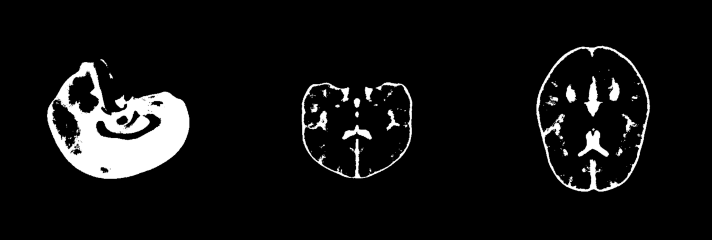

In [19]:
CSF = np.copy(seg_data_mni_array)
CSF[seg_mask_mni_array==1] = 1
CSF[seg_mask_mni_array!=1] = 0

fig, axs = plt.subplots(1, 3, figsize=(10, 10))
fig.set_tight_layout('pad')
plt.subplots_adjust(wspace=0, hspace=0)
axs[0].imshow(CSF[:, :, CSF.shape[2]//2], vmin=0, vmax=1, cmap="Greys_r")
axs[0].axis('off')
axs[1].imshow(CSF[:, CSF.shape[1]//2, :], vmin=0, vmax=1, cmap="Greys_r")
axs[1].axis('off')
axs[2].imshow(CSF[CSF.shape[0]//2, :, :], vmin=0, vmax=1, cmap="Greys_r")
axs[2].axis('off')
fig.set_facecolor("Black")

### Grey matter

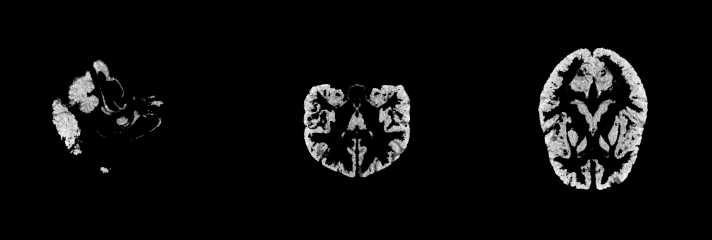

In [20]:
GM = np.copy(seg_data_mni_array)
GM[seg_mask_mni_array!=2] = 0

fig, axs = plt.subplots(1, 3, figsize=(10, 10))
fig.set_tight_layout('pad')
plt.subplots_adjust(wspace=0, hspace=0)
axs[0].imshow(GM[:, :, GM.shape[2]//2], vmin=0, vmax=60, cmap="Greys_r")
axs[0].axis('off')
axs[1].imshow(GM[:, GM.shape[1]//2, :], vmin=0, vmax=60, cmap="Greys_r")
axs[1].axis('off')
axs[2].imshow(GM[GM.shape[0]//2, :, :], vmin=0, vmax=60, cmap="Greys_r")
axs[2].axis('off')
fig.set_facecolor("Black")

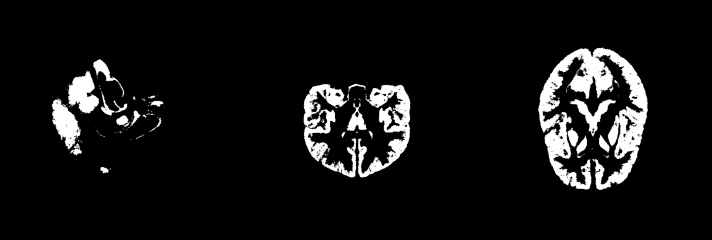

In [21]:
GM_mask = np.copy(GM)
GM_mask[GM_mask!=0] = 1

fig, axs = plt.subplots(1, 3, figsize=(10, 10))
fig.set_tight_layout('pad')
plt.subplots_adjust(wspace=0, hspace=0)
axs[0].imshow(GM_mask[:, :, GM_mask.shape[2]//2], vmin=0, vmax=1, cmap="Greys_r")
axs[0].axis('off')
axs[1].imshow(GM_mask[:, GM_mask.shape[1]//2, :], vmin=0, vmax=1, cmap="Greys_r")
axs[1].axis('off')
axs[2].imshow(GM_mask[GM_mask.shape[0]//2, :, :], vmin=0, vmax=1, cmap="Greys_r")
axs[2].axis('off')
fig.set_facecolor("Black")

### White matter

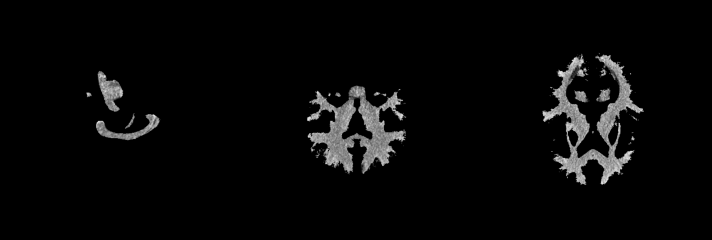

In [22]:
WM = np.copy(seg_data_mni_array)
WM[seg_mask_mni_array!=3] = 0

fig, axs = plt.subplots(1, 3, figsize=(10, 10))
fig.set_tight_layout('pad')
plt.subplots_adjust(wspace=0, hspace=0)
axs[0].imshow(WM[:, :, WM.shape[2]//2], vmin=0, vmax=60, cmap="Greys_r")
axs[0].axis('off')
axs[1].imshow(WM[:, WM.shape[1]//2, :], vmin=0, vmax=60, cmap="Greys_r")
axs[1].axis('off')
axs[2].imshow(WM[WM.shape[0]//2, :, :], vmin=0, vmax=60, cmap="Greys_r")
axs[2].axis('off')
fig.set_facecolor("Black")

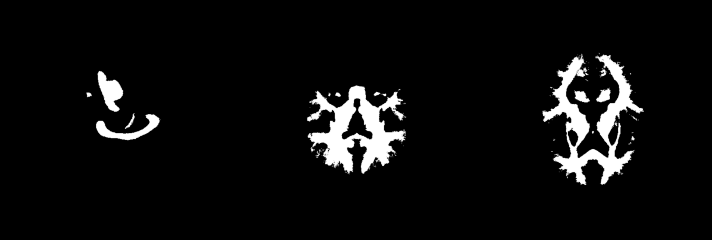

In [23]:
WM_mask = np.copy(WM)
WM_mask[WM_mask!=0] = 1

fig, axs = plt.subplots(1, 3, figsize=(10, 10))
fig.set_tight_layout('pad')
plt.subplots_adjust(wspace=0, hspace=0)
axs[0].imshow(WM_mask[:, :, WM_mask.shape[2]//2], vmin=0, vmax=1, cmap="Greys_r")
axs[0].axis('off')
axs[1].imshow(WM_mask[:, WM_mask.shape[1]//2, :], vmin=0, vmax=1, cmap="Greys_r")
axs[1].axis('off')
axs[2].imshow(WM_mask[WM_mask.shape[0]//2, :, :], vmin=0, vmax=1, cmap="Greys_r")
axs[2].axis('off')
fig.set_facecolor("Black")

## Return in real space

### Make invert transform

In [24]:
displacement_field_inverter = sitk.InvertDisplacementFieldImageFilter()
displacement_field_inverter.SetMaximumNumberOfIterations(50)
displacement_field_inverter.SetEnforceBoundaryCondition(True)

image = sitk.ReadImage("./temp_tr1.nii", sitk.sitkFloat32)
outTx = sitk.ReadTransform("./tr2.tfm")

displacement_field_image = sitk.TransformToDisplacementField(outTx, 
                                  sitk.sitkVectorFloat64,
                                  image.GetSize(),
                                  image.GetOrigin(),
                                  image.GetSpacing(),
                                  image.GetDirection())

In [25]:
%%time
inverted_transform = sitk.DisplacementFieldTransform(displacement_field_inverter.Execute(displacement_field_image))
outTx_inverse = sitk.CompositeTransform(inverted_transform)

CPU times: total: 43min 3s
Wall time: 3min 20s


In [26]:
outTx = sitk.ReadTransform("./tr1.tfm")
fixed = sitk.ReadImage("./CT_brain.nii", sitk.sitkFloat32)

### Grey matter img, mask in real space & volume

In [27]:
GM_img = sitk.GetImageFromArray(GM)
GM_img.SetSpacing(seg_data_mni.GetSpacing())
GM_img.SetDirection(seg_data_mni.GetDirection())
GM_img.SetOrigin(seg_data_mni.GetOrigin())

GM_mask_img = sitk.GetImageFromArray(GM_mask)
GM_mask_img.SetSpacing(seg_data_mni.GetSpacing())
GM_mask_img.SetDirection(seg_data_mni.GetDirection())
GM_mask_img.SetOrigin(seg_data_mni.GetOrigin())

In [28]:
spline_trans_temp = sitk.Resample(GM_img, image, outTx_inverse, sitk.sitkBSpline, 0.0, image.GetPixelID())

rigid_trans_temp = sitk.Resample(spline_trans_temp, fixed, outTx.GetInverse(), sitk.sitkBSpline, \
                                 0.0, fixed.GetPixelID())
sitk.WriteImage(rigid_trans_temp, "./GM_img.nii")

In [29]:
spline_trans_temp = sitk.Resample(GM_mask_img, image, outTx_inverse, sitk.sitkNearestNeighbor, 0.0, image.GetPixelID())

rigid_trans_temp = sitk.Resample(spline_trans_temp, fixed, outTx.GetInverse(), sitk.sitkNearestNeighbor, \
                                 0.0, fixed.GetPixelID())
sitk.WriteImage(rigid_trans_temp, "./GM_mask_img.nii")

In [30]:
mask = sitk.ReadImage("./GM_mask_img.nii", sitk.sitkFloat32)
calc_img = sitk.GetArrayFromImage(mask)
space = mask.GetSpacing()
voxel = np.prod(space)
vol = voxel*np.sum(calc_img) / 1000
print(f'Grey matter volume: {"%.1f" % vol} ml.')

Grey matter volume: 656.0 ml.


### White matter img, mask in real space & volume

In [31]:
WM_img = sitk.GetImageFromArray(WM)
WM_img.SetSpacing(seg_data_mni.GetSpacing())
WM_img.SetDirection(seg_data_mni.GetDirection())
WM_img.SetOrigin(seg_data_mni.GetOrigin())

WM_mask_img = sitk.GetImageFromArray(WM_mask)
WM_mask_img.SetSpacing(seg_data_mni.GetSpacing())
WM_mask_img.SetDirection(seg_data_mni.GetDirection())
WM_mask_img.SetOrigin(seg_data_mni.GetOrigin())

In [32]:
spline_trans_temp = sitk.Resample(WM_img, image, outTx_inverse, sitk.sitkBSpline, 0.0, image.GetPixelID())

rigid_trans_temp = sitk.Resample(spline_trans_temp, fixed, outTx.GetInverse(), sitk.sitkBSpline, \
                                 0.0, fixed.GetPixelID())
sitk.WriteImage(rigid_trans_temp, "./WM_img.nii")

In [33]:
spline_trans_temp = sitk.Resample(WM_mask_img, image, outTx_inverse, sitk.sitkNearestNeighbor, 0.0, image.GetPixelID())

rigid_trans_temp = sitk.Resample(spline_trans_temp, fixed, outTx.GetInverse(), sitk.sitkNearestNeighbor, \
                                 0.0, fixed.GetPixelID())
sitk.WriteImage(rigid_trans_temp, "./WM_mask_img.nii")

In [34]:
mask = sitk.ReadImage("./WM_mask_img.nii", sitk.sitkFloat32)
calc_img = sitk.GetArrayFromImage(mask)
space = mask.GetSpacing()
voxel = np.prod(space)
vol = voxel*np.sum(calc_img) / 1000
print(f'White matter volume: {"%.1f" % vol} ml.')

White matter volume: 457.7 ml.


### CSF mask in real space & volume

In [35]:
CSF_mask_img = sitk.GetImageFromArray(CSF)
CSF_mask_img.SetSpacing(seg_data_mni.GetSpacing())
CSF_mask_img.SetDirection(seg_data_mni.GetDirection())
CSF_mask_img.SetOrigin(seg_data_mni.GetOrigin())

In [36]:
spline_trans_temp = sitk.Resample(CSF_mask_img, image, outTx_inverse, sitk.sitkNearestNeighbor, 0.0, image.GetPixelID())

rigid_trans_temp = sitk.Resample(spline_trans_temp, fixed, outTx.GetInverse(), sitk.sitkNearestNeighbor, \
                                 0.0, fixed.GetPixelID())
sitk.WriteImage(rigid_trans_temp, "./CSF_mask_img.nii")

In [37]:
mask = sitk.ReadImage("./CSF_mask_img.nii", sitk.sitkFloat32)
calc_img = sitk.GetArrayFromImage(mask)
space = mask.GetSpacing()
voxel = np.prod(space)
vol = voxel*np.sum(calc_img) / 1000
print(f'CSF volume: {"%.1f" % vol} ml.')

CSF volume: 262.7 ml.


### Masks real space

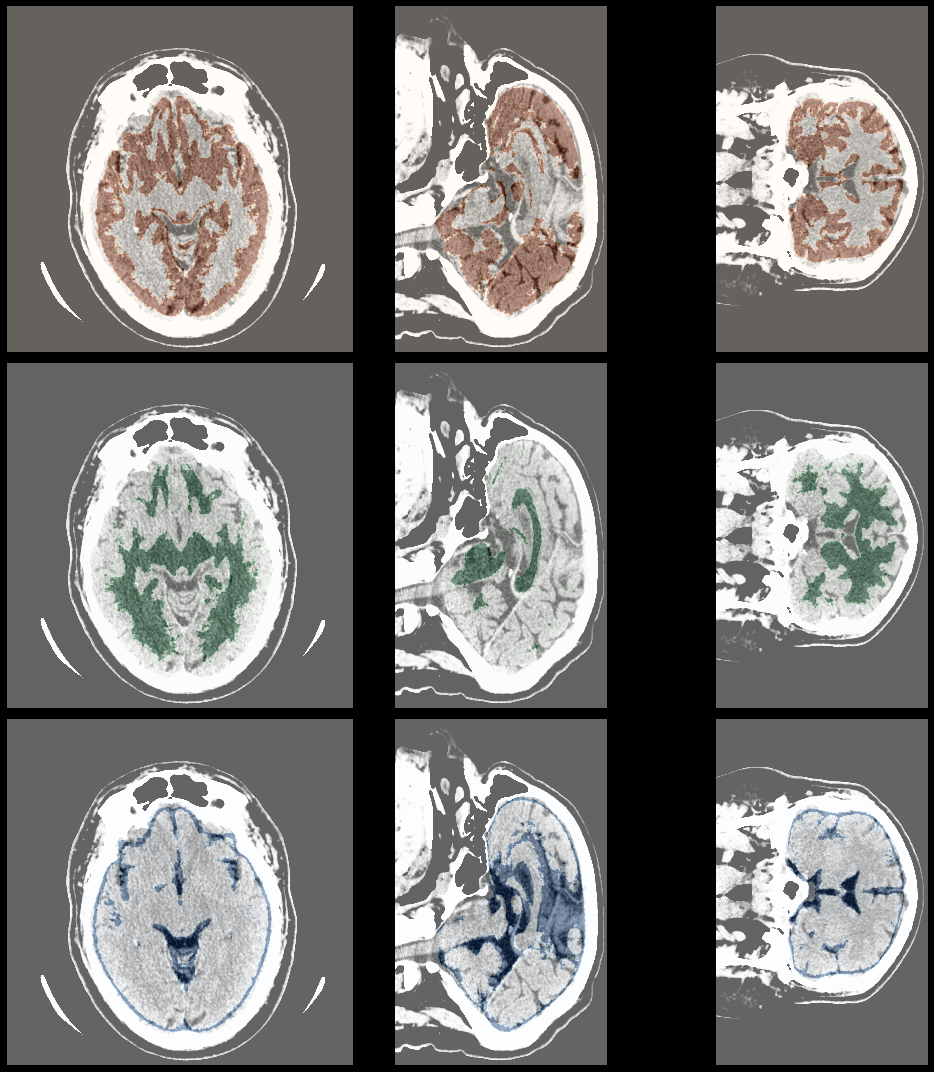

In [38]:
CT_raw_array = sitk.GetArrayFromImage(sitk.ReadImage("./CT.nii", sitk.sitkFloat32)).transpose([1,2,0])
vis_GM_mask_array = sitk.GetArrayFromImage(sitk.ReadImage("./GM_mask_img.nii", sitk.sitkFloat32)).transpose([1,2,0])
vis_WM_mask_array = sitk.GetArrayFromImage(sitk.ReadImage("./WM_mask_img.nii", sitk.sitkFloat32)).transpose([1,2,0])
vis_CSF_mask_array = sitk.GetArrayFromImage(sitk.ReadImage("./CSF_mask_img.nii", sitk.sitkFloat32)).transpose([1,2,0])

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.set_tight_layout('pad')
plt.subplots_adjust(wspace=0, hspace=0)
axs[0,0].imshow(CT_raw_array[:, :, CT_raw_array.shape[2]//2], vmin=0, vmax=60, cmap="Greys_r")
axs[0,0].imshow(vis_GM_mask_array[:, :, vis_GM_mask_array.shape[2]//2], vmin=0, vmax=1, cmap="Oranges", alpha=0.4)
axs[0,0].axis('off')
axs[0,1].imshow(CT_raw_array[:, CT_raw_array.shape[1]//2, :], vmin=0, vmax=60, cmap="Greys_r")
axs[0,1].imshow(vis_GM_mask_array[:, vis_GM_mask_array.shape[1]//2, :], vmin=0, vmax=1, cmap="Oranges", alpha=0.4)
axs[0,1].axis('off')
axs[0,2].imshow(CT_raw_array[CT_raw_array.shape[0]//2, :, :], vmin=0, vmax=60, cmap="Greys_r")
axs[0,2].imshow(vis_GM_mask_array[vis_GM_mask_array.shape[0]//2, :, :], vmin=0, vmax=1, cmap="Oranges", alpha=0.4)
axs[0,2].axis('off')

axs[1,0].imshow(CT_raw_array[:, :, CT_raw_array.shape[2]//2], vmin=0, vmax=60, cmap="Greys_r")
axs[1,0].imshow(vis_WM_mask_array[:, :, vis_WM_mask_array.shape[2]//2], vmin=0, vmax=1, cmap="Greens", alpha=0.4)
axs[1,0].axis('off')
axs[1,1].imshow(CT_raw_array[:, CT_raw_array.shape[1]//2, :], vmin=0, vmax=60, cmap="Greys_r")
axs[1,1].imshow(vis_WM_mask_array[:, vis_WM_mask_array.shape[1]//2, :], vmin=0, vmax=1, cmap="Greens", alpha=0.4)
axs[1,1].axis('off')
axs[1,2].imshow(CT_raw_array[CT_raw_array.shape[0]//2, :, :], vmin=0, vmax=60, cmap="Greys_r")
axs[1,2].imshow(vis_WM_mask_array[vis_WM_mask_array.shape[0]//2, :, :], vmin=0, vmax=1, cmap="Greens", alpha=0.4)
axs[1,2].axis('off')

axs[2,0].imshow(CT_raw_array[:, :, CT_raw_array.shape[2]//2], vmin=0, vmax=60, cmap="Greys_r")
axs[2,0].imshow(vis_CSF_mask_array[:, :, vis_CSF_mask_array.shape[2]//2], vmin=0, vmax=1, cmap="Blues", alpha=0.4)
axs[2,0].axis('off')
axs[2,1].imshow(CT_raw_array[:, CT_raw_array.shape[1]//2, :], vmin=0, vmax=60, cmap="Greys_r")
axs[2,1].imshow(vis_CSF_mask_array[:, vis_CSF_mask_array.shape[1]//2, :], vmin=0, vmax=1, cmap="Blues", alpha=0.4)
axs[2,1].axis('off')
axs[2,2].imshow(CT_raw_array[CT_raw_array.shape[0]//2, :, :], vmin=0, vmax=60, cmap="Greys_r")
axs[2,2].imshow(vis_CSF_mask_array[vis_CSF_mask_array.shape[0]//2, :, :], vmin=0, vmax=1, cmap="Blues", alpha=0.4)
axs[2,2].axis('off')
fig.set_facecolor("Black")